Objetivo: Implementar un modelo de Machine Learning (XGBoost) para un pronóstico a largo plazo (52 semanas) utilizando un enfoque recursivo, para evitar la fuga de datos (data leakage) y simular un escenario de predicción real.

## 1. Configuración del Entorno

Se importan todas las librerías necesarias y se carga el DataFrame nacional limpio V4.

In [105]:
# --- Librerías Principales ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools

# --- Modelado ---
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# --- Carga de Datos ---
# Se utiliza la versión "Nacional" que ya está limpia, agregada y con outliers tratados.
path_data = '../data/processed/data_processed_v4_National_NoAcum_Total.csv'
df = pd.read_csv(path_data)

print("Datos nacionales cargados exitosamente.\n")
print(df.info())

Datos nacionales cargados exitosamente.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Year         570 non-null    int64 
 1   Week         570 non-null    int64 
 2   Date         570 non-null    object
 3   Total_Cases  570 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 17.9+ KB
None


## 2. Preparación de la Serie de Tiempo

Se prepara el DataFrame para el análisis de series de tiempo: se establece un índice de fecha, se asegura una frecuencia semanal consistente y se cuentan posibles huecos generados antes de rellenarlos.

In [106]:
# 1. Se convierte la columna 'Date' a formato datetime y se establece como índice.
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# 2. Se asegura que la frecuencia del índice sea semanal (anclada al DOMINGO).
df = df.asfreq('W-SUN')

# 3. Conteo de Valores Faltantes
# Antes de rellenar, se cuentan cuántos NaNs se crearon.
nans_creados = df['Total_Cases'].isnull().sum()

if nans_creados > 0:
    print(f"DIAGNÓSTICO: La función .asfreq() encontró {nans_creados} semanas faltantes y las añadió como NaN.")
else:
    print("DIAGNÓSTICO: La serie de tiempo ya estaba completa. No se crearon NaNs.")

# 4. Se rellenan con 0 los posibles huecos.
df['Total_Cases'] = df['Total_Cases'].fillna(0)

print("\nDataFrame preparado con índice de tiempo (anclado a Domingo):")
print(df.head())

DIAGNÓSTICO: La función .asfreq() encontró 3 semanas faltantes y las añadió como NaN.

DataFrame preparado con índice de tiempo (anclado a Domingo):
              Year  Week  Total_Cases
Date                                 
2014-01-12  2014.0   2.0          4.0
2014-01-19  2014.0   3.0         29.0
2014-01-26  2014.0   4.0         47.0
2014-02-02  2014.0   5.0         36.0
2014-02-09  2014.0   6.0         42.0


## 3. Ingeniería de Características

Se creará un conjunto de características que el modelo de ML pueda usar. Un modelo como XGBoost no entiende el tiempo por sí solo, por lo que debemos "enseñarle" patrones temporales creando variables explícitas.

Se crearán dos tipos de características:
- Lags (Retrasos): El valor de las semanas anteriores. Es la "memoria" del modelo.
- Variables de Calendario: El mes, semana del año, etc. Es la "estacionalidad" del modelo.

In [107]:
print("\n--- Iniciando Ingeniería de Características ---\n")

# Se crea el DataFrame 'df_features' que contendrá los predictores (X) y el objetivo (y)
df_features = df.copy()
df_features = df_features.sort_index()

# 1. Creación de Lags (Retrasos)
# Se crearán lags para las 4 semanas anteriores
n_lags = 4
for i in range(1, n_lags + 1):
    df_features[f'lag_{i}'] = df_features['Total_Cases'].shift(i)

# 2. Creación de Variables de Calendario
df_features['mes'] = df_features.index.month
df_features['semana_del_anio'] = df_features.index.isocalendar().week.astype(int)
df_features['dia_del_anio'] = df_features.index.dayofyear
df_features['año'] = df_features.index.year

# 3. Limpieza de NaNs
# Se eliminan las primeras filas que no tienen datos de lag
df_features = df_features.dropna()

print("DataFrame con características (features) creado exitosamente.\n")
print(df_features.head())


--- Iniciando Ingeniería de Características ---

DataFrame con características (features) creado exitosamente.

              Year  Week  Total_Cases  lag_1  lag_2  lag_3  lag_4  mes  \
Date                                                                     
2014-02-09  2014.0   6.0         42.0   36.0   47.0   29.0    4.0    2   
2014-02-16  2014.0   7.0         30.0   42.0   36.0   47.0   29.0    2   
2014-02-23  2014.0   8.0         45.0   30.0   42.0   36.0   47.0    2   
2014-03-02  2014.0   9.0         34.0   45.0   30.0   42.0   36.0    3   
2014-03-09  2014.0  10.0         28.0   34.0   45.0   30.0   42.0    3   

            semana_del_anio  dia_del_anio   año  
Date                                             
2014-02-09                6            40  2014  
2014-02-16                7            47  2014  
2014-02-23                8            54  2014  
2014-03-02                9            61  2014  
2014-03-09               10            68  2014  


## 4. Definición de X (Features) e y (Target)

Se divide el DataFrame en:
- y: Nuestro objetivo (target). El número de casos que queremos predecir.
- X: Nuestras características (features). Todas las "pistas" que el modelo usará para hacer la predicción (lags y calendario).

In [108]:
# 'y' (el objetivo) es la columna original de casos totales
y = df_features['Total_Cases']

# 'X' (las características) son todas las columnas que creamos, EXCEPTO el objetivo
X = df_features.drop('Total_Cases', axis=1)

print("\nDefinición de X (features) e y (target) completada.")
print("\nFeatures (X):")
print(X.head())
print("\nTarget (y):")
print(y.head())


Definición de X (features) e y (target) completada.

Features (X):
              Year  Week  lag_1  lag_2  lag_3  lag_4  mes  semana_del_anio  \
Date                                                                         
2014-02-09  2014.0   6.0   36.0   47.0   29.0    4.0    2                6   
2014-02-16  2014.0   7.0   42.0   36.0   47.0   29.0    2                7   
2014-02-23  2014.0   8.0   30.0   42.0   36.0   47.0    2                8   
2014-03-02  2014.0   9.0   45.0   30.0   42.0   36.0    3                9   
2014-03-09  2014.0  10.0   34.0   45.0   30.0   42.0    3               10   

            dia_del_anio   año  
Date                            
2014-02-09            40  2014  
2014-02-16            47  2014  
2014-02-23            54  2014  
2014-03-02            61  2014  
2014-03-09            68  2014  

Target (y):
Date
2014-02-09    42.0
2014-02-16    30.0
2014-02-23    45.0
2014-03-02    34.0
2014-03-09    28.0
Name: Total_Cases, dtype: float64


## 5. División de Datos (Train/Test Split Cronológico)

Se dividirá el conjunto de datos en entrenamiento y prueba. A diferencia de otros problemas de ML, en las series de tiempo esta división no puede ser aleatoria. Para simular un pronóstico real, se debe usar un corte cronológico. Se reservarán las últimas 52 semanas (un año) como el conjunto de prueba (Test set), y el resto de los datos se usará para el entrenamiento (Train set).

In [109]:
# Se parte de 'X' (features) e 'y' (target) del Paso 4

# --- Paso 5: División de Datos Cronológica ---

# Se define el horizonte de pronóstico (52 semanas)
HORIZONTE_PRONOSTICO = 52

# Se seleccionan los datos de entrenamiento (todos menos los últimos 52)
X_train = X[:-HORIZONTE_PRONOSTICO]
y_train = y[:-HORIZONTE_PRONOSTICO]

# Se seleccionan los datos de prueba (solo los últimos 52)
X_test = X[-HORIZONTE_PRONOSTICO:]
y_test = y[-HORIZONTE_PRONOSTICO:]

print("División de datos completada.")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de X_test:  {X_test.shape}")
print(f"Forma de y_test:  {y_test.shape}")

# Se verifican las fechas para estar seguros
print(f"\nFecha de inicio del entrenamiento: {X_train.index.min().date()}")
print(f"Fecha de fin del entrenamiento:    {X_train.index.max().date()}")
print(f"Fecha de inicio de la prueba:        {X_test.index.min().date()}")
print(f"Fecha de fin de la prueba:          {X_test.index.max().date()}")

División de datos completada.
Forma de X_train: (514, 10)
Forma de y_train: (514,)
Forma de X_test:  (52, 10)
Forma de y_test:  (52,)

Fecha de inicio del entrenamiento: 2014-02-09
Fecha de fin del entrenamiento:    2023-12-17
Fecha de inicio de la prueba:        2023-12-24
Fecha de fin de la prueba:          2024-12-29


## 6. Entrenamiento del Modelo Base (One-Step-Ahead)

El primer paso para un pronóstico recursivo es entrenar un modelo que sea experto en predecir solo una semana adelante (un pronóstico "one-step-ahead"). Entrenaremos nuestro XGBoost usando las X_train e y_train que ya preparamos. 

Se realizará una búsqueda en malla (GridSearch) para encontrar una combinación de hiperparámetros más óptima. Para respetar la naturaleza de los datos, se usará TimeSeriesSplit como estrategia de validación cruzada. Se medirán dos tiempos: el tiempo total de la optimización (búsqueda) y el tiempo del re-entrenamiento final (el que se usará para comparar).

In [110]:
# Se parte de 'X_train' e 'y_train' del Paso 5

# --- Paso 6: Optimización (GridSearch) ---

# 1. Se define el modelo
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# 2. Se define una rejilla de parámetros
param_grid_xgb = {
    'n_estimators': [500, 1000, 1500],  # Número de árboles
    'max_depth': [3, 5],               # Profundidad máxima de cada árbol
    'learning_rate': [0.01, 0.05, 0.1],  # Tasa de aprendizaje
    'subsample': [0.7, 1.0]            # Fracción de datos para cada árbol (controla overfitting)
}
# Total de combinaciones a probar: 3 * 2 * 3 * 2 = 36 combinaciones

# 3. Se define la estrategia de validación cruzada
tscv = TimeSeriesSplit(n_splits=3)

# 4. Se configura el GridSearchCV
total_fits = len(list(itertools.product(*param_grid_xgb.values()))) * tscv.get_n_splits()

print(f"Iniciando optimización (GridSearch Profundo)...")
print(f"Total de combinaciones: {len(list(itertools.product(*param_grid_xgb.values())))}")
print(f"Total de 'fits' (modelos a entrenar): {total_fits}")

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# 5. Se ejecuta la búsqueda (Optimización)
start_time_opt = time.time()
grid_search_xgb.fit(X_train, y_train)
optimization_time = time.time() - start_time_opt

print(f"\nMejores parámetros encontrados: {grid_search_xgb.best_params_}")
print(f"Tiempo de Optimización (GridSearch): {optimization_time:.2f} segundos")

# 6. Se entrena el Modelo Final (una sola vez)
print("\nEntrenando el modelo final con los mejores parámetros...")

model = grid_search_xgb.best_estimator_
training_time = grid_search_xgb.refit_time_

print(f"Modelo base final (XGBoost) entrenado en {training_time:.2f} segundos.")

Iniciando optimización (GridSearch Profundo)...
Total de combinaciones: 36
Total de 'fits' (modelos a entrenar): 108
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
Tiempo de Optimización (GridSearch): 5.61 segundos

Entrenando el modelo final con los mejores parámetros...
Modelo base final (XGBoost) entrenado en 0.09 segundos.


## Optimización (Rejilla Más Puntual)

Las búsquedas anteriores revelaron que el modelo prefiere consistentemente parámetros simples (learning_rate=0.01, max_depth=3). Los resultados para n_estimators sugieren que el valor óptimo está entre 100 y 500. Se implementará una búsqueda final y enfocada para encontrar el número exacto de árboles en ese rango, bloqueando los otros parámetros a sus valores óptimos ya descubiertos.

In [111]:
# Se parte de 'X_train' e 'y_train' del Paso 5

# --- Paso 6: Optimización (GridSearch - REJILLA PUNTUAL) ---

# 1. Se define el modelo
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# 2. Se define una rejilla de parámetros FINAL Y ENFOCADA
# Se bloquean los parámetros ya conocidos y se explora el único que falta.
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],  # Vaor óptimo por descubrir
    'max_depth': [3],                          # Se bloquea el ganador
    'learning_rate': [0.01],                   # Se bloquea el ganador
    'subsample': [1.0]                         # Se bloquea el ganador
}
# Total de combinaciones a probar: 5 * 1 * 1 * 1 = 5 combinaciones

# 3. Se define la estrategia de validación cruzada
tscv = TimeSeriesSplit(n_splits=3)

# 4. Se configura el GridSearchCV
total_fits = len(list(itertools.product(*param_grid_xgb.values()))) * tscv.get_n_splits()

print(f"Iniciando optimización (GridSearch Puntual)...")
print(f"Total de combinaciones: {len(list(itertools.product(*param_grid_xgb.values())))}")
print(f"Total de 'fits' (modelos a entrenar): {total_fits}")

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# 5. Se ejecuta la búsqueda (Optimización)
start_time_opt = time.time()
grid_search_xgb.fit(X_train, y_train)
optimization_time = time.time() - start_time_opt

print(f"\nMejores parámetros encontrados: {grid_search_xgb.best_params_}")
print(f"Tiempo de Optimización (GridSearch): {optimization_time:.2f} segundos")

# 6. Se entrena el Modelo Final (una sola vez)
print("\nEntrenando el modelo final con los mejores parámetros...")

model = grid_search_xgb.best_estimator_
training_time = grid_search_xgb.refit_time_

print(f"Modelo base final (XGBoost) entrenado en {training_time:.2f} segundos.")

Iniciando optimización (GridSearch Puntual)...
Total de combinaciones: 5
Total de 'fits' (modelos a entrenar): 15
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Tiempo de Optimización (GridSearch): 0.26 segundos

Entrenando el modelo final con los mejores parámetros...
Modelo base final (XGBoost) entrenado en 0.02 segundos.


## 7. Implementación del Pronóstico Recursivo

En lugar de predecir X_test directamente (lo cual causaría data leakage), se simulará un pronóstico real. Se iniciará un bucle de 52 pasos (nuestro horizonte de pronóstico). En cada paso, el modelo predecirá una semana y esa predicción se usará para construir las características (lags) de la semana siguiente.

In [112]:
print("\n--- Paso 7: Iniciando Pronóstico Recursivo (52 semanas) ---")

# 1. Se toma la última fila de datos REALES (el final de X_train)
# Esta será la base para predecir la PRIMERA semana del futuro.
last_known_features = X_train.iloc[-1].values
last_known_date = X_train.index[-1]

# 2. Se prepara una lista para guardar las 52 predicciones
predictions_recursive = []

# 3. Se inicializa el vector de características para el bucle
# Este vector se irá "actualizando" con predicciones
current_features = last_known_features.copy()

# 4. Se itera 52 veces (para las 52 semanas del horizonte de prueba)
for i in range(HORIZONTE_PRONOSTICO):
    # 4a. Se reformatea el vector para que XGBoost lo acepte (1 fila, n_features)
    current_features_reshaped = current_features.reshape(1, -1)
    
    # 4b. Se predice la SIGUIENTE semana
    # (El [0] es para obtener el número en lugar de un array)
    next_prediction = model.predict(current_features_reshaped)[0]
    
    # 4c. Se guarda la predicción
    predictions_recursive.append(next_prediction)
    
    # 4d. --- ACTUALIZACIÓN RECURSIVA DE FEATURES ---
    # Esta es la parte más importante.
    
    # Se actualizan los lags:
    # El lag_1 se vuelve la predicción que acabamos de hacer
    # El lag_2 se vuelve el lag_1 anterior
    # ...y así sucesivamente (n_lags = 4)
    current_features[0:n_lags] = np.roll(current_features[0:n_lags], 1)
    current_features[0] = next_prediction # [lag_1, lag_2, lag_3, lag_4]
    
    # Se actualizan las features de calendario:
    # Se calcula la fecha de la nueva predicción
    next_date = last_known_date + pd.DateOffset(weeks=i+1)
    
    # Se actualizan 'mes', 'semana_del_anio', 'dia_del_anio', 'año'
    # (Los índices 4, 5, 6, 7 corresponden a esas columnas)
    current_features[n_lags] = next_date.month
    current_features[n_lags+1] = next_date.isocalendar().week
    current_features[n_lags+2] = next_date.dayofyear
    current_features[n_lags+3] = next_date.year

print("Pronóstico recursivo completado.")


--- Paso 7: Iniciando Pronóstico Recursivo (52 semanas) ---
Pronóstico recursivo completado.


## 8. Evaluación del Pronóstico Recursivo

Se comparará el pronóstico recursivo (predictions_recursive) con los valores reales (y_test) guardados. Esta métrica es metodológicamente correcta y nos dirá el verdadero rendimiento del modelo en un escenario de pronóstico a 52 semanas, incluyendo la acumulación de error.


--- Paso 8: Evaluación del Pronóstico Recursivo ---
Métricas del Pronóstico Recursivo a 52 semanas:
MAE:  21.46
RMSE: 50.69
MAPE: 57.50%


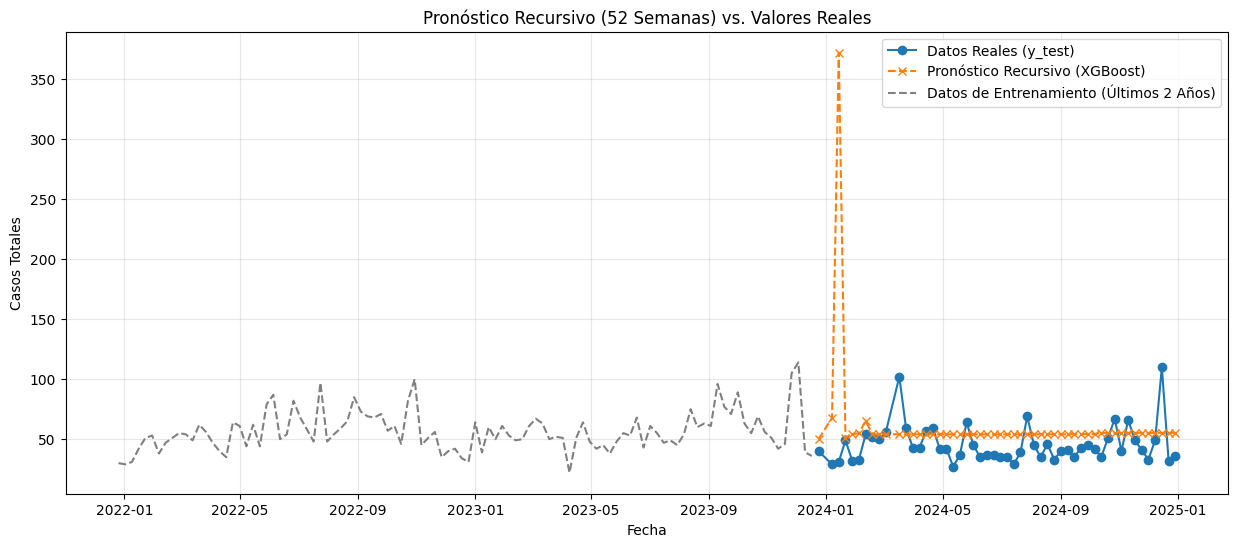

In [113]:
print("\n--- Paso 8: Evaluación del Pronóstico Recursivo ---")

# 1. Se extraen los valores reales
y_true = y_test.values

# 2. Se calculan las métricas
mae_recursive = mean_absolute_error(y_true, predictions_recursive)
rmse_recursive = np.sqrt(mean_squared_error(y_true, predictions_recursive))
mape_recursive = mean_absolute_percentage_error(y_true, predictions_recursive) * 100

print(f"Métricas del Pronóstico Recursivo a 52 semanas:")
print(f"MAE:  {mae_recursive:.2f}")
print(f"RMSE: {rmse_recursive:.2f}")
print(f"MAPE: {mape_recursive:.2f}%")

# --- 3. Visualización (CORREGIDA) ---
# Se usan las variables correctas (y_test, y_train)

plt.figure(figsize=(15, 6))

# Se grafican los datos de prueba:
# Se usa 'y_test.index' para el eje X y 'y_true' para el eje Y
plt.plot(y_test.index, y_true, 'o-', label='Datos Reales (y_test)')
# Se usa 'y_test.index' para el eje X y las predicciones para el eje Y
plt.plot(y_test.index, predictions_recursive, 'x--', label='Pronóstico Recursivo (XGBoost)')

# Se grafican los datos de entrenamiento para dar contexto:
# Se usa 'y_train' (que definimos en el Paso 5)
plt.plot(y_train.index[-104:], y_train.values[-104:], label='Datos de Entrenamiento (Últimos 2 Años)', color='gray', linestyle='--')

plt.title('Pronóstico Recursivo (52 Semanas) vs. Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Casos Totales')
plt.legend()
plt.grid(alpha=0.3)
plt.show()